### Youtube as a political weapon :

Youtube is a main platform for sharing political videos. However, recently It was a main weapon to inflame the political polarisation in the United States and deepening the political conflict between the right and left. Using the YouNiverse dataset we try to answer those questions: 

1- Did the negativity sentiment and political polarization in political videos increase overtime?

2- Has Youtube has been used as a political weapon? Who initiated this tone and benefited from it?

3- Using also the "radicalization dataset" to further explore the use of youtube as a political weapon in the (pre-)election period for 2017

---

#### 1) Data Reduction:

The data is too big to fit in memory..and we are only interested in political videos. So we start by reducing the dataset to only keep those 3 categories:

`['Nonprofits & Activism', 'People & Blogs', 'News & Politics']`

In [1]:
#!pip install pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [7]:
df_sb_f = pd.read_csv("data/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])
df_sb_f.head(5)


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [8]:
print("channel count in TimeSeries table:", df_sb_f['channel'].nunique())
df_sb_f["category"].unique()

chanell count in TimeSeries table: 133516


array(['Film and Animation', 'Music', 'Comedy', 'Gaming',
       'Science & Technology', 'Sports', 'Entertainment', 'Education',
       'Nonprofits & Activism', 'People & Blogs', 'Howto & Style',
       'News & Politics', 'Travel & Events', 'Autos & Vehicles',
       'Pets & Animals', nan], dtype=object)

In [9]:
df_sb_f = df_sb_f.loc[df_sb_f["category"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
print("channel count in TimeSeries table after filteration:", df_sb_f['channel'].nunique())

chanell count in TimeSeries table after filteration: 21163


Now we save the reduced timeseries table

In [10]:
df_sb_f.to_pickle("data/df_timeseries_reduced.tsv.gz")

In [11]:

df_ch_f = pd.read_csv("data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])
df_ch_f.head(5)


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [13]:
print("channel count in TimeSeries table", df_ch_f['channel'].nunique())
df_ch_f['category_cc'].unique()

channel count in TimeSeries table 136470


array(['Gaming', 'Education', 'Entertainment', 'Howto & Style', 'Sports',
       'Music', 'Film and Animation', 'Comedy', 'Nonprofits & Activism',
       'People & Blogs', 'News & Politics', 'Science & Technology',
       'Pets & Animals', 'Autos & Vehicles', 'Travel & Events', nan],
      dtype=object)

In [15]:
df_ch_f = df_ch_f.loc[df_ch_f["category_cc"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
print("channel count in TimeSeries table after filteration:", df_ch_f['channel'].nunique())

channel count in TimeSeries table after filteration: 21645


In [16]:
df_ch_f.to_pickle("data/df_channels_reduced.tsv.gz")

In [ ]:

count = 0
count_after = 0
chunksize = 10 ** 5
flag=False
for chunk in tqdm(pd.read_json("data/yt_metadata_en.jsonl.gz",lines=True, chunksize=chunksize)):
    count += chunk['display_id'].nunique() 
    chunk = chunk.loc[chunk["categories"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
    if not flag:
        flag=True
        chunk.to_csv('data/yt_metadata_reduced.tsv.gz', index=False)
    else:
        chunk.to_csv('data/yt_metadata_reduced.tsv.gz', index=False, header=False, mode='a')
    count_after += chunk['display_id'].nunique()

print("videos count: ", count)
print("videos count after reduction: ", count_after)


---
#### 2) Data Exploration & Processing:

General Data analysis on the three categories of channels we’re interested in

In [2]:
#Reading the data from reduced files
df_ch_f = pd.read_pickle('data/df_channels_reduced.tsv.gz')
df_sb_f = pd.read_pickle('data/df_timeseries_reduced.tsv.gz')

df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])
columns = ['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count']
vd_frames = []
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns,lineterminator='\n')):
       chunk["dummmy"] = 1
       vd_frames.append(chunk)
df_vd_f = pd.concat(vd_frames)
df_vd_f = df_vd_f[1:]

166it [05:44,  2.08s/it]


First we explore the dataset after reduction into the three main categories. As per the below figures, fig 1 shows the number of channels per category as can be seen from the graph, "People & Blogs" Category is the highest around 18k channels. From fig 2, we can see how subscribers count is distributed among the three categories. Since the distribution of subscribers count is heavily skewed we've used log scaled count. We can observe that "News and Politics" category has the highest median with more than 50% of the channels have more than 60k subscribers.

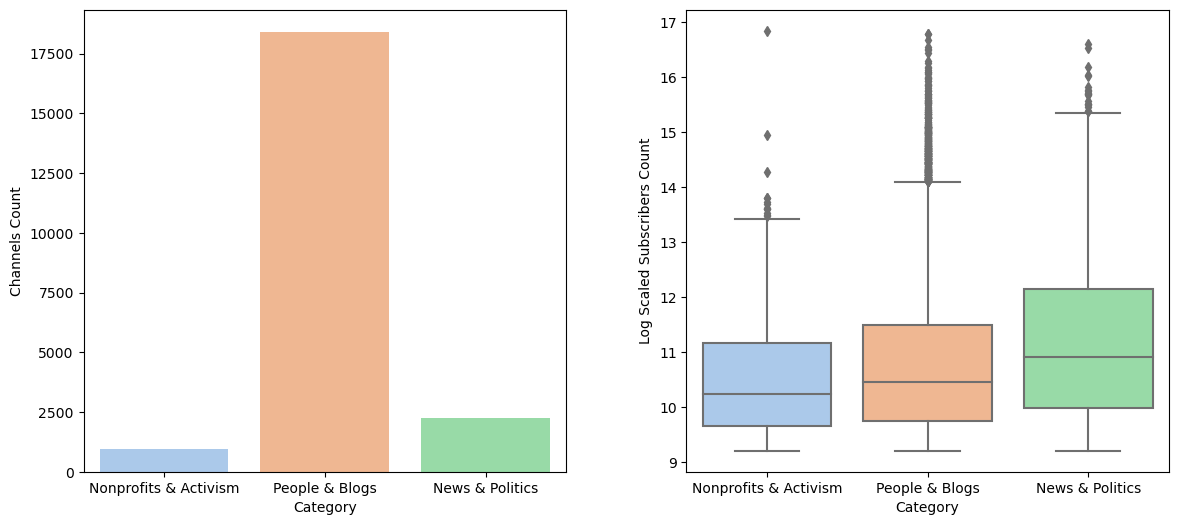

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"wspace": 0.25, "hspace": 0.1})

ax1 = sns.countplot(ax = ax1, data = df_ch_f['channel'], x = df_ch_f['category_cc'], y=None, palette="pastel")
ax1.set(xlabel='Category', ylabel='Channels Count')
ax2 = sns.boxplot(ax = ax2, x = df_ch_f['category_cc'], y = np.log(df_ch_f['subscribers_cc']), data = df_ch_f['channel'], palette="pastel")
ax2.set(xlabel='Category', ylabel='Log Scaled Subscribers Count')

plt.show()

Furthermore, we want to explore the activity of channels by category measured by video production on quarter basis. As well as views by category.

In [4]:
#split data into three categories for visualization
NonProfit_df = df_vd_f.loc[df_vd_f['categories'] == "Nonprofits & Activism"]
Blogs_df = df_vd_f.loc[df_vd_f['categories'] == "People & Blogs"]
News_df = df_vd_f.loc[df_vd_f['categories'] == "News & Politics"]

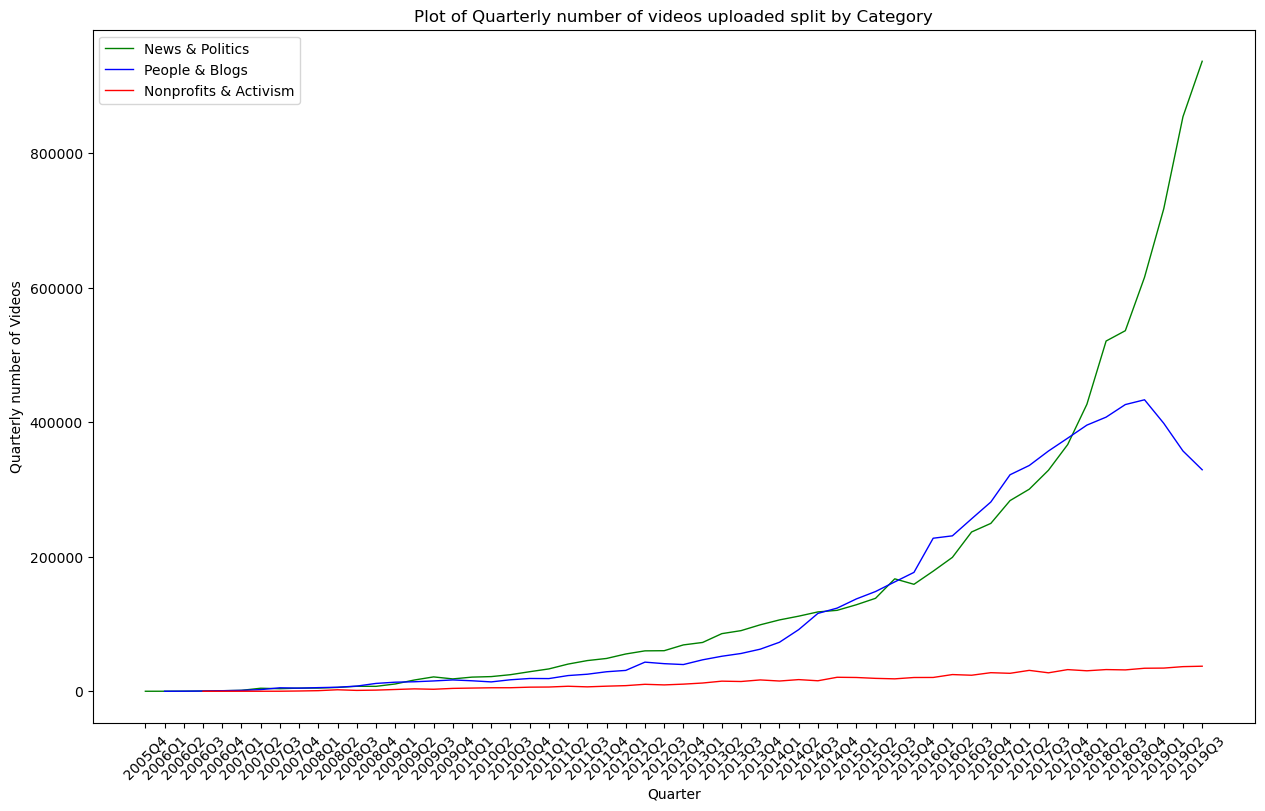

In [5]:
#Group by quarter for view count and video production
NonProfit_df['upload_date'] = pd.to_datetime(NonProfit_df['upload_date'], errors='coerce')
NonProfit_df['view_count'] = pd.to_numeric(NonProfit_df['view_count'])
grouped_by_month_NonProfit = NonProfit_df.groupby(pd.PeriodIndex(NonProfit_df['upload_date'], freq="Q"))

Blogs_df['upload_date'] = pd.to_datetime(Blogs_df['upload_date'], errors='coerce')
Blogs_df['view_count'] = pd.to_numeric(Blogs_df['view_count'])
grouped_by_month_Blogs = Blogs_df.groupby(pd.PeriodIndex(Blogs_df['upload_date'], freq="Q"))

News_df['upload_date'] = pd.to_datetime(News_df['upload_date'], errors='coerce')
News_df['view_count'] = pd.to_numeric(News_df['view_count'])
grouped_by_month_News = News_df.groupby(pd.PeriodIndex(News_df['upload_date'], freq="Q"))


videos_cnt_NonProfit  = grouped_by_month_NonProfit['display_id'].nunique()[1:-1]
videos_cnt_NonProfit = pd.DataFrame({'count' : videos_cnt_NonProfit}).reset_index()
videos_cnt_NonProfit = videos_cnt_NonProfit.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_Blogs  = grouped_by_month_Blogs['display_id'].nunique()[1:-1]
videos_cnt_Blogs = pd.DataFrame({'count' : videos_cnt_Blogs}).reset_index()
videos_cnt_Blogs = videos_cnt_Blogs.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_News  = grouped_by_month_News['display_id'].nunique()[1:-1]
videos_cnt_News = pd.DataFrame({'count' : videos_cnt_News}).reset_index()
videos_cnt_News = videos_cnt_News.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

#Plot for production of videos by quarter
ax.plot(videos_cnt_News.index.map(str).to_list(), videos_cnt_News['count'].to_list(), linewidth=1, color='g', label='News & Politics')
ax.plot(videos_cnt_Blogs.index.map(str).to_list(), videos_cnt_Blogs['count'].to_list(), linewidth=1, color='b', label='People & Blogs')
ax.plot(videos_cnt_NonProfit.index.map(str).to_list(), videos_cnt_NonProfit['count'].to_list(), linewidth=1, color='r', label='Nonprofits & Activism')

ax.set_xticklabels(videos_cnt_News.index.map(str).to_list(), rotation=45)


plt.xlabel('Quarter')
plt.ylabel('Quarterly number of Videos')
plt.title('Plot of Quarterly number of videos uploaded split by Category')
plt.legend()
plt.show()

As can be seen from the above graph, video production in the "News & Politics" category started to grow exponentially from 2015 and it exceeded the other two categories starting 2017.

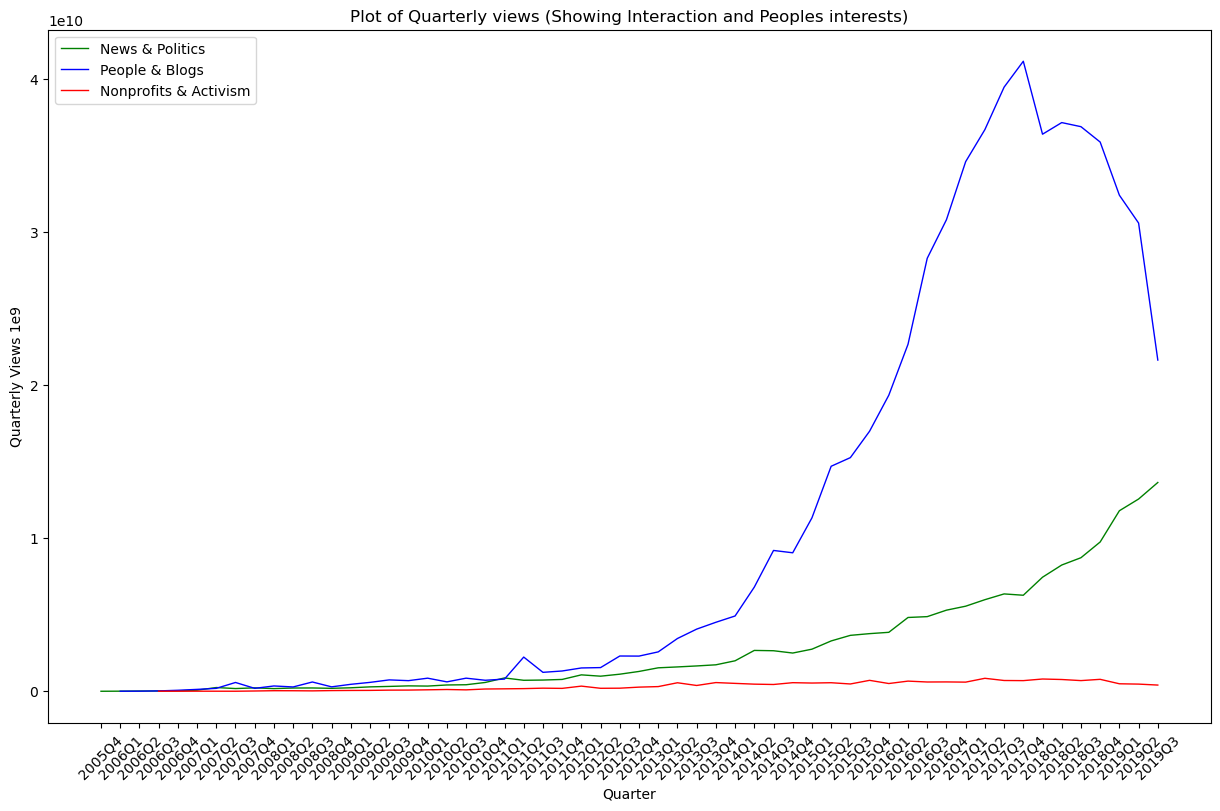

In [6]:
#Plot for production of views count by quarter
videos_cnt_NonProfit  = grouped_by_month_NonProfit['view_count'].sum()[1:-1]
videos_cnt_NonProfit = pd.DataFrame({'count' : videos_cnt_NonProfit}).reset_index()
videos_cnt_NonProfit = videos_cnt_NonProfit.set_index('upload_date').resample('Q').asfreq().fillna(0)


videos_cnt_Blogs  = grouped_by_month_Blogs['view_count'].sum()[1:-1]
videos_cnt_Blogs = pd.DataFrame({'count' : videos_cnt_Blogs}).reset_index()
videos_cnt_Blogs = videos_cnt_Blogs.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_News  = grouped_by_month_News['view_count'].sum()[1:-1]
videos_cnt_News = pd.DataFrame({'count' : videos_cnt_News}).reset_index()
videos_cnt_News = videos_cnt_News.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(videos_cnt_News.index.map(str).to_list(), videos_cnt_News['count'].to_list(), linewidth=1, color='g', label='News & Politics')
ax.plot(videos_cnt_Blogs.index.map(str).to_list(), videos_cnt_Blogs['count'].to_list(), linewidth=1, color='b', label='People & Blogs')
ax.plot(videos_cnt_NonProfit.index.map(str).to_list(), videos_cnt_NonProfit['count'].to_list(), linewidth=1, color='r', label='Nonprofits & Activism')
ax.set_xticklabels(videos_cnt_News.index.map(str).to_list(), rotation=45)

plt.xlabel('Quarter')
plt.ylabel('Quarterly Views 1e9')
plt.title('Plot of Quarterly views (Showing Interaction and Peoples interests)')
plt.legend()
plt.show()

The above graph shows that people's interest in "News & Politics" category is growing overtime while interest in "People & Blogs" catgory started to drop beginning of 2017.

---
#### 3) Analyzing sentiment and heat in youtube:


**a) measuring sentiment:**
    
[We use a pretrained model to do sentiment analysis](https://github.com/pysentimiento/pysentimiento). The Base model is BERTweet, a RoBERTa model trained on English tweets and then finetuned on SemEval 2017 corpus (around ~40k tweets).
BERTweet is a large-scale pre-trained language model for English Tweets. It uses transformer methods to represent each word as a vector which can then be fed to a classifier to do classification.
    
Given a string representing an english sentence the model returns `{POS: positive sentiment, NEG: positive sentiment, NEU: neutral}` labels. . 

In [4]:
#!pip install -q transformers
#!pip3 install emoji==0.6.0
from transformers import pipeline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt

sentiment_pipeline = pipeline("sentiment-analysis","finiteautomata/bertweet-base-sentiment-analysis",
 truncation=True,
   device='cuda:0',
   batch_size=64,
   num_workers=16)
def sent_analysis(desc):
    #print(desc)
    out = sentiment_pipeline(desc)
    return out

print(sent_analysis('The economy is going towards a recession. The layoffs will begin soon.'))
print(sent_analysis('Trump is amazing! He is making a merica great again.'))
print(sent_analysis('Trump is a nightmare for the country!'))
print(sent_analysis('Trump visits china for the first time, we will see how that goes!'))
print(sent_analysis('Order your Trump 2020 shirts here:'))

[{'label': 'NEG', 'score': 0.9643341898918152}]
[{'label': 'POS', 'score': 0.9926153421401978}]
[{'label': 'NEG', 'score': 0.9839464426040649}]
[{'label': 'NEU', 'score': 0.9028584957122803}]
[{'label': 'NEU', 'score': 0.5477039217948914}]


**b) measuring heat/polarization per video:**

We had an initial idea to find a metric for polarization by measuring the ratio of dislikes to the total interactions (likes and dislikes). We only focused on "People & Blogs" category.

In [3]:
#Reading "People & Blogs" category
blogs_df = pd.DataFrame(columns=["upload_date", "dislike_count", "like_count", "categories"])
for chunk in tqdm(pd.read_json("data/yt_metadata_en.jsonl.gz", lines=True, chunksize=10**5)):
    chunk = chunk[["upload_date", "dislike_count", "like_count", "categories"]]
    chunk = chunk.loc[chunk["categories"] == 'People & Blogs']
    blogs_df = pd.concat([blogs_df, chunk])

blogs_df.head(5)

730it [28:37,  2.35s/it]


,upload_date,dislike_count,like_count,categories
264,2015-11-07 00:00:00,0.0,8.0,People & Blogs
1783,2019-02-05 00:00:00,613.0,49464.0,People & Blogs
1784,2019-01-31 00:00:00,588.0,32726.0,People & Blogs
1785,2019-01-22 00:00:00,1177.0,86222.0,People & Blogs
1786,2019-01-15 00:00:00,673.0,30596.0,People & Blogs


In [8]:
blogs_df_clean = blogs_df.reset_index(drop=True).drop('categories', axis=1)
blogs_df_clean.to_pickle('data/blogs.tsv.gz')

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


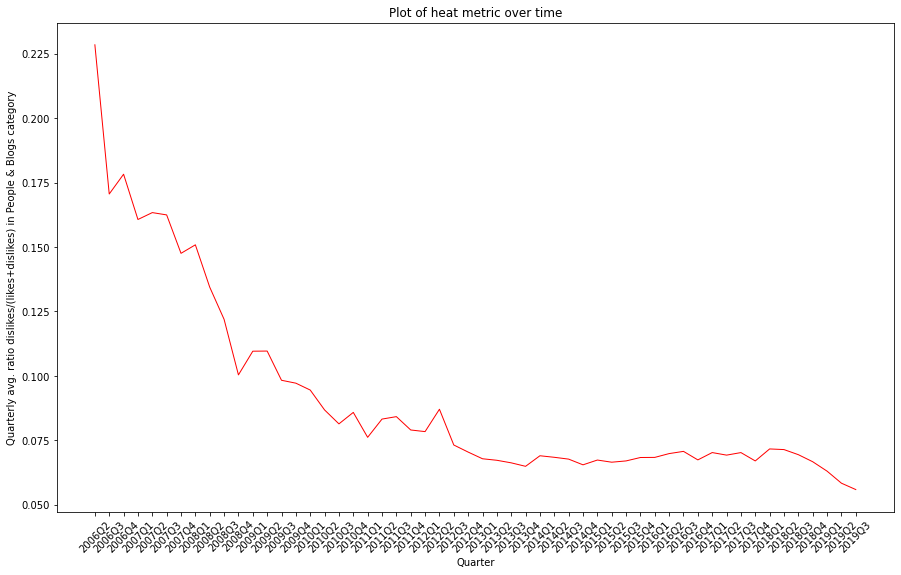

In [12]:
#Calculating and plotting the heat metric overtime
blogs_df = pd.read_pickle('data/blogs.tsv.gz')
blogs_df['upload_date'] = pd.to_datetime(blogs_df['upload_date'], errors='coerce')
blogs_df['metric_2'] = blogs_df['dislike_count']/(blogs_df['like_count']+blogs_df['dislike_count'])
# Heat Metric used  --> Dividing the number of dislikes by the numebr of likes + dislikes
# Grouping by month for metric
grouped_by_month_metric2 = blogs_df.groupby(pd.PeriodIndex(blogs_df['upload_date'], freq="Q"))


metric_2_mean = grouped_by_month_metric2['metric_2'].mean()[1:-1]
metric_2_mean = pd.DataFrame({'mean_ratio' : metric_2_mean}).reset_index()
metric_2_mean = metric_2_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(metric_2_mean.index.map(str).to_list(), metric_2_mean['mean_ratio'].to_list(), linewidth=1, color='r')
ax.set_xticklabels(metric_2_mean.index.map(str).to_list(), rotation=45)

plt.xlabel('Quarter')
plt.ylabel('Quarterly avg. ratio dislikes/(likes+dislikes) in People & Blogs category')
plt.title('Plot of heat metric over time')
plt.show()


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


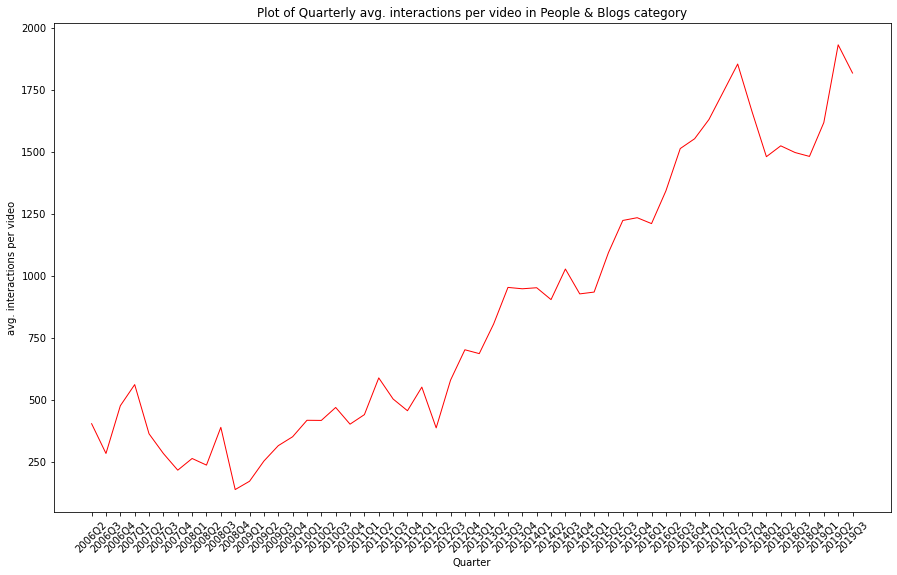

In [13]:
#calculating and plotting avg interactions
blogs_df = pd.read_pickle('data/blogs.tsv.gz')
blogs_df['upload_date'] = pd.to_datetime(blogs_df['upload_date'], errors='coerce')
blogs_df['interactions'] = (blogs_df['like_count']+blogs_df['dislike_count'])
# Heat Metric used  --> Dividing the number of dislikes by the numebr of likes + dislikes
# Grouping by month for metric
grouped_by_month = blogs_df.groupby(pd.PeriodIndex(blogs_df['upload_date'], freq="Q"))


interactions = grouped_by_month['interactions'].mean()[1:-1]
interactions = pd.DataFrame({'interactions' : interactions}).reset_index()
interactions = interactions.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(interactions.index.map(str).to_list(), interactions['interactions'].to_list(), linewidth=1, color='r')
ax.set_xticklabels(interactions.index.map(str).to_list(), rotation=45)

plt.xlabel('Quarter')
plt.ylabel('avg. interactions per video')
plt.title('Plot of Quarterly avg. interactions per video in People & Blogs category')
plt.show()

As can be seen from the above graph, peoples average interactions per video is growing overtime for this category. Which means that people are having stronger opinions about the content either positive or negative (which can be a sign of radicalization)


##### **Q2** Youtube effect in politics? Who benefited from it?

We will focus on the presidents/presidential candidiates to show who benifited the most from youtube. 
We will try to analyse and compare between:
- Donald Trump
- Barack Obama
- Hillary Clinton

On three different aspects:

- Coverage and Publicity (which we will measure by views count/videos count).
- Polarization (which we will measure with our heat metric).
- Sentiment (which can be measured with the sentiment analysis model we showed earlier).


We search for the names of the 3 figures in the videos discription and only keep the videos where the nemes appear. We save the dataframes on disk.

In [29]:
from tqdm import tqdm
# trump
columns = ['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count']
trump_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns, usecols=range(len(columns)), lineterminator='\n')):
    trump_df = pd.concat([trump_df, chunk[chunk['description'].astype(str).str.contains('trump', case=False, na=False)]])

print("Number of videos for Trump:", trump_df['display_id'].nunique())
trump_df.to_pickle('./data/trump_data.tsv.gz')
del trump_df

#obama
obama_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns, usecols=range(len(columns)), lineterminator='\n')):
    obama_df = pd.concat([obama_df, chunk[chunk['description'].str.contains('obama', case=False, na=False)]])

print("Number of videos for Obama:", obama_df['display_id'].nunique())
obama_df.to_pickle('./data/obama_data.tsv.gz')


#clinton
clinton_df = pd.DataFrame(columns=columns)
for chunk in tqdm(pd.read_csv('data/yt_metadata_reduced.tsv.gz', chunksize=10**5, names=columns, usecols=range(len(columns)), lineterminator='\n')):
    clinton_df = pd.concat([clinton_df, chunk[chunk['description'].astype(str).str.contains('Hillary', case=False, na=False)]])

print("Number of videos for Hillary:", clinton_df['display_id'].nunique())
clinton_df.to_pickle('./data/clinton_data.tsv.gz')


70it [02:03,  1.61s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (5,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
72it [02:06,  1.63s/it]/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
166it [05:07,  1.85s/it]


Number of videos for Trump: 349042


166it [04:55,  1.78s/it]


Number of videos for Obama: 120308


166it [05:12,  1.88s/it]


Number of videos for Hillary: 46333


Number of videos for Trump: 349091

Number of videos for Obama: 120319

Number of videos for Hillary: 46336

Now we compare the number of videos posted for each of the three figures per Quarter.

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


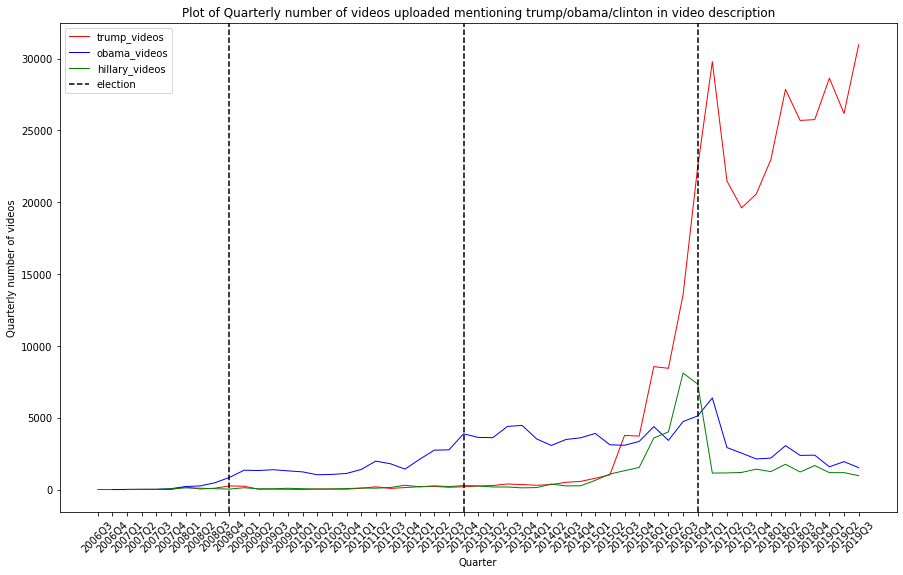

In [2]:
#Plotting view count and number of videos on quarter basis for Trump, Obama and Clinton
import datetime
import pandas as pd
import matplotlib.pyplot as plt
trump_df = pd.read_pickle('./data/trump_data.tsv.gz')
obama_df = pd.read_pickle('./data/obama_data.tsv.gz')
clinton_df = pd.read_pickle('./data/clinton_data.tsv.gz')

trump_df['upload_date'] = pd.to_datetime(trump_df['upload_date'], errors='coerce')
trump_df['view_count'] = pd.to_numeric(trump_df['view_count'])
grouped_by_month_trump = trump_df.groupby(pd.PeriodIndex(trump_df['upload_date'], freq="Q"))

obama_df['upload_date'] = pd.to_datetime(obama_df['upload_date'], errors='coerce')
obama_df['view_count'] = pd.to_numeric(obama_df['view_count'])
grouped_by_month_obama = obama_df.groupby(pd.PeriodIndex(obama_df['upload_date'], freq="Q"))

clinton_df['upload_date'] = pd.to_datetime(clinton_df['upload_date'], errors='coerce')
clinton_df['view_count'] = pd.to_numeric(clinton_df['view_count'])
grouped_by_month_clinton = clinton_df.groupby(pd.PeriodIndex(clinton_df['upload_date'], freq="Q"))


videos_cnt_trump  = grouped_by_month_trump['display_id'].nunique()[1:-1]
videos_cnt_trump = pd.DataFrame({'count' : videos_cnt_trump}).reset_index()
videos_cnt_trump = videos_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_obama  = grouped_by_month_obama['display_id'].nunique()[1:-1]
videos_cnt_obama = pd.DataFrame({'count' : videos_cnt_obama}).reset_index()
videos_cnt_obama = videos_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

videos_cnt_clinton  = grouped_by_month_clinton['display_id'].nunique()[1:-1]
videos_cnt_clinton = pd.DataFrame({'count' : videos_cnt_clinton}).reset_index()
videos_cnt_clinton = videos_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(videos_cnt_trump.index.map(str).to_list(), videos_cnt_trump['count'].to_list(), linewidth=1, color='r', label='trump_videos')
ax.plot(videos_cnt_obama.index.map(str).to_list(), videos_cnt_obama['count'].to_list(), linewidth=1, color='b', label='obama_videos')
ax.plot(videos_cnt_clinton.index.map(str).to_list(), videos_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='hillary_videos')

ax.set_xticklabels(videos_cnt_trump.index.map(str).to_list(), rotation=45)

plt.axvline(x='2008Q4', label='election', ls='--', color='black')
plt.axvline(x='2012Q4', ls='--', color='black')
plt.axvline(x='2016Q4', ls='--', color='black')
plt.xlabel('Quarter')
plt.ylabel('Quarterly number of videos')
plt.title('Plot of Quarterly number of videos uploaded mentioning trump/obama/clinton in video description')
plt.legend()
plt.show()

Then we also compare the number of view over time.

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


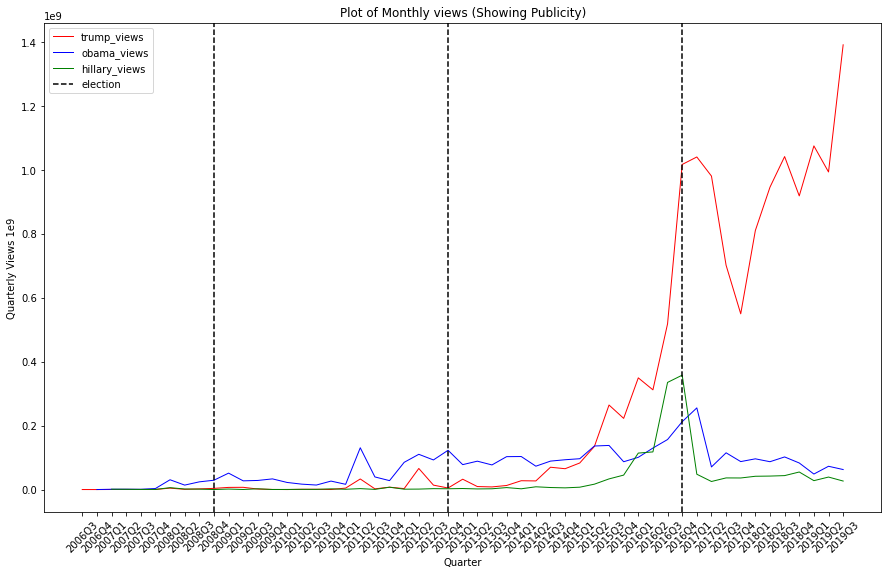

In [3]:
#Number of views for each political figure
views_cnt_trump  = grouped_by_month_trump['view_count'].sum()[1:-1]
views_cnt_trump = pd.DataFrame({'count' : views_cnt_trump}).reset_index()
views_cnt_trump = views_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)


views_cnt_obama  = grouped_by_month_obama['view_count'].sum()[1:-1]
views_cnt_obama = pd.DataFrame({'count' : views_cnt_obama}).reset_index()
views_cnt_obama = views_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

views_cnt_clinton  = grouped_by_month_clinton['view_count'].sum()[1:-1]
views_cnt_clinton = pd.DataFrame({'count' : views_cnt_clinton}).reset_index()
views_cnt_clinton = views_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(views_cnt_trump.index.map(str).to_list(), views_cnt_trump['count'].to_list(), linewidth=1, color='r', label='trump_views')
ax.plot(views_cnt_obama.index.map(str).to_list(), views_cnt_obama['count'].to_list(), linewidth=1, color='b', label='obama_views')
ax.plot(views_cnt_clinton.index.map(str).to_list(), views_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='hillary_views')
ax.set_xticklabels(views_cnt_trump.index.map(str).to_list(), rotation=45)
plt.axvline(x='2008Q4', label='election', ls='--', color='black')
plt.axvline(x='2012Q4', ls='--', color='black')
plt.axvline(x='2016Q4', ls='--', color='black')
plt.xlabel('Quarter')
plt.ylabel('Quarterly Views 1e9')
plt.title('Plot of Monthly views (Showing Publicity)')
plt.legend()
plt.show()

Seems like trump got much more coverage & publicity from youtube compared to his opponent (hillary) and his predeccessor (obama). 

His videos got more attention as well. We measure that with the average views per videos.

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


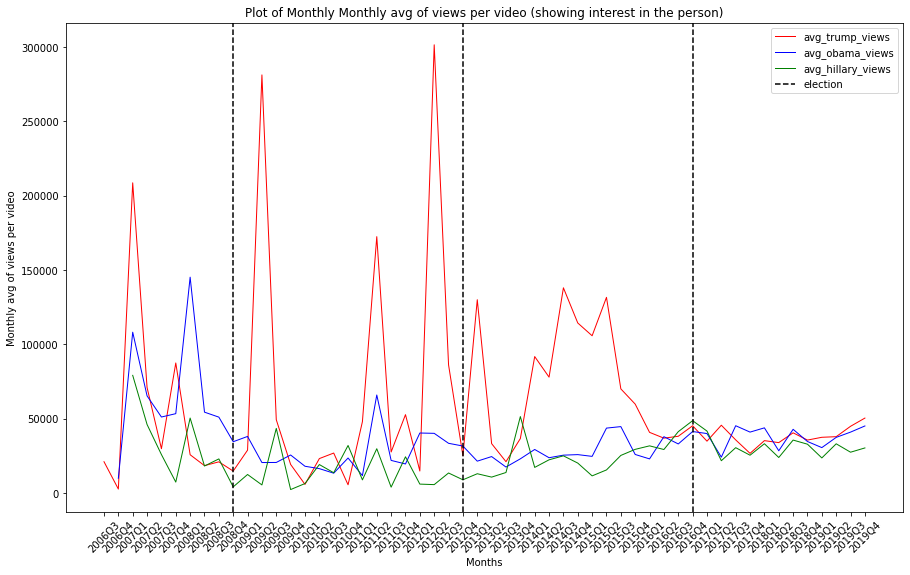

In [4]:
# Average of views per video for obama, trumo and clinton
views_cnt_trump  = grouped_by_month_trump['view_count'].mean()[1:]
views_cnt_trump = pd.DataFrame({'count' : views_cnt_trump}).reset_index()
views_cnt_trump = views_cnt_trump.set_index('upload_date').resample('Q').asfreq().fillna(0)


views_cnt_obama  = grouped_by_month_obama['view_count'].mean()[1:]
views_cnt_obama = pd.DataFrame({'count' : views_cnt_obama}).reset_index()
views_cnt_obama = views_cnt_obama.set_index('upload_date').resample('Q').asfreq().fillna(0)

views_cnt_clinton  = grouped_by_month_clinton['view_count'].mean()[1:]
views_cnt_clinton = pd.DataFrame({'count' : views_cnt_clinton}).reset_index()
views_cnt_clinton = views_cnt_clinton.set_index('upload_date').resample('Q').asfreq().fillna(0)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

ax.plot(views_cnt_trump.index.map(str).to_list(), views_cnt_trump['count'].to_list(), linewidth=1, color='r', label='avg_trump_views')
ax.plot(views_cnt_obama.index.map(str).to_list(), views_cnt_obama['count'].to_list(), linewidth=1, color='b', label='avg_obama_views')
ax.plot(views_cnt_clinton.index.map(str).to_list(), views_cnt_clinton['count'].to_list(), linewidth=1, color='g', label='avg_hillary_views')
ax.set_xticklabels(views_cnt_trump.index.map(str).to_list(), rotation=45)
plt.axvline(x='2008Q4', label='election', ls='--', color='black')
plt.axvline(x='2012Q4', ls='--', color='black')
plt.axvline(x='2016Q4', ls='--', color='black')
plt.xlabel('Months')
plt.ylabel('Monthly avg of views per video')
plt.title('Plot of Monthly Monthly avg of views per video (showing interest in the person)')
plt.legend()
plt.show()

Trump got much more coverage & publicity & attention from youtube compared to his opponent (hillary) and his predeccessor (obama). At some point he became a trend. as his average views per video, number of videos and number of views increased.

Now we want to also take a look at how the sentiment about each of them developed overtime. Plot them together to get more insights.


In [2]:

# helper function that takes a data frame and analyzes the sentiment of the description over time
def plot_sentiment(df, figure):
    if not os.path.exists(f'./data/{figure}_sent.tsv.gz'):
        out = sent_analysis(df['description'].to_list())
        sentiment = pd.DataFrame.from_dict(out)
        sentiment.to_pickle(f'./data/{figure}_sent.tsv.gz')
    
    sentiment = pd.read_pickle(f'./data/{figure}_sent.tsv.gz')

    df = df.set_index(sentiment.index)
    df = df.join(sentiment['label'])
    df = df.join(sentiment['score'])
    df['label'] = df['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
    df['score'] = df['label']*df['score']
    df = df.drop(['label', 'categories', 'crawl_date', 'duration', 'description', 'tags', 'title'], axis=1)
    df['interactions'] = (df['like_count']+df['dislike_count'])

    
    df['upload_date'] = pd.to_datetime(df['upload_date'], errors='coerce')
    df['dislike_count'] = pd.to_numeric(df['dislike_count'], errors='coerce')
    df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')
    print(len(df))
    df = df.dropna()
    print(len(df))

    df['heat'] = df['dislike_count']/(df['like_count']+df['dislike_count'])
    grouped_by_month = df.groupby(pd.PeriodIndex(df['upload_date'], freq="Q"))
    

    sent_mean = grouped_by_month['score'].mean()[1:-1]
    sent_mean = pd.DataFrame({'mean_ratio' : sent_mean}).reset_index()
    sent_mean = sent_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)

    heat_mean = grouped_by_month['heat'].mean()[1:-1]
    heat_mean = pd.DataFrame({'mean_ratio' : heat_mean}).reset_index()
    heat_mean = heat_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)

    return sent_mean, heat_mean


120466
116614
349594
342912
46351
45668


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


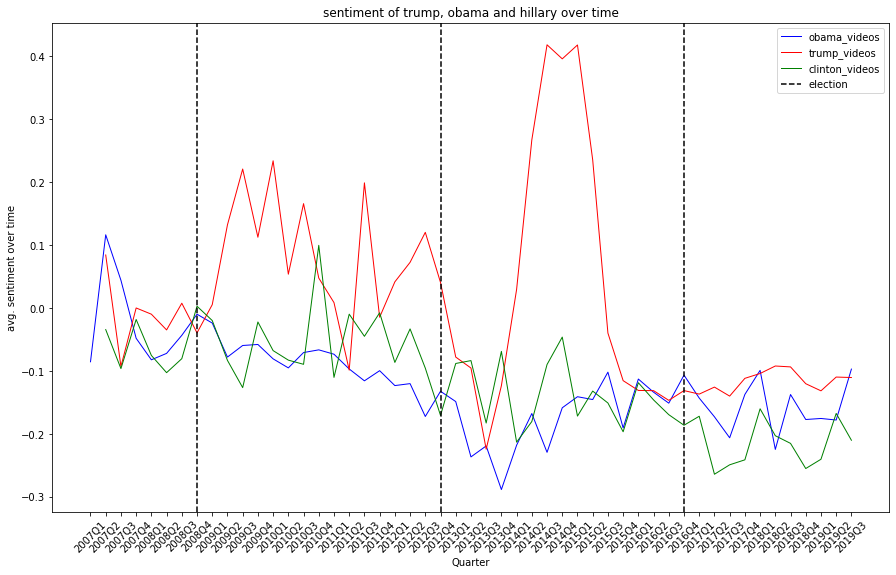

In [5]:
# plotting sentiment over time for trump, obama and clinton in the same fugure ti compare

obama_df = pd.read_pickle(f'./data/obama_data.tsv.gz')
sent_obama, heat_obama = plot_sentiment(obama_df, "obama")
del obama_df

trump_df = pd.read_pickle('./data/trump_data.tsv.gz')
sent_trump, heat_trump = plot_sentiment(trump_df, "trump")
del trump_df
 
clinton_df = pd.read_pickle('./data/clinton_data.tsv.gz')
sent_clinton, heat_clinton = plot_sentiment(clinton_df, "clinton")
del clinton_df

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(sent_obama.index.map(str).to_list(), sent_obama['mean_ratio'].to_list(), linewidth=1, color='b', label='obama_videos')
ax.plot(sent_trump.index.map(str).to_list()[2:], sent_trump['mean_ratio'].to_list()[2:], linewidth=1, color='r', label='trump_videos')
ax.plot(sent_clinton.index.map(str).to_list(), sent_clinton['mean_ratio'].to_list(), linewidth=1, color='g', label='clinton_videos')
ax.set_xticklabels(sent_obama.index.map(str).to_list(), rotation=45)
plt.axvline(x='2008Q4', label='election', ls='--', color='black')
plt.axvline(x='2012Q4', ls='--', color='black')
plt.axvline(x='2016Q4', ls='--', color='black')
plt.xlabel('Quarter')
plt.ylabel(f'avg. sentiment over time')
plt.title(f'sentiment of trump, obama and hillary over time')
plt.legend()
plt.show()



Then we also compare the heat metric for their videos.

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


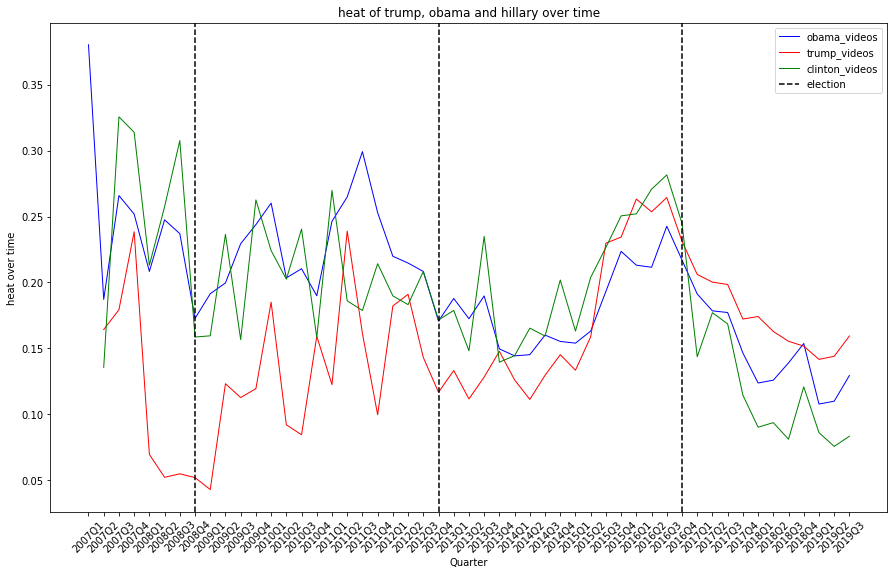

In [6]:
# plotting heat metric for obama, trump and clinton.
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(heat_obama.index.map(str).to_list(), heat_obama['mean_ratio'].to_list(), linewidth=1, color='b', label='obama_videos')
ax.plot(heat_trump.index.map(str).to_list()[2:], heat_trump['mean_ratio'].to_list()[2:], linewidth=1, color='r', label='trump_videos')
ax.plot(heat_clinton.index.map(str).to_list(), heat_clinton['mean_ratio'].to_list(), linewidth=1, color='g', label='clinton_videos')
ax.set_xticklabels(heat_obama.index.map(str).to_list(), rotation=45)
plt.axvline(x='2008Q4', label='election', ls='--', color='black')
plt.axvline(x='2012Q4', ls='--', color='black')
plt.axvline(x='2016Q4', ls='--', color='black')
plt.xlabel('Quarter')
plt.ylabel(f'heat over time')
plt.title(f'heat of trump, obama and hillary over time')
plt.legend()
plt.show()





##### **Q3** Using the radicalization dataset to further explore the use of youtube as a political weapon in the (pre-) election period for 2017.

In order to explore whether youtube contributed to the election victory of the Republicans 2017 (where Trump was elected), our idea is to analyze the statistics of "right" videos compared to the statistics of "left" and "center" videos. 

That is, we study and compare the growth of the amount of published videos for the three categorical videos ("left", "right" and "center") starting in the pre-election period of 2017. On top of that, we also want to analyze the the evolvement of the heat-metric (as described in part 3-Q1-b) during that period to assess the user engagement for the three different political categories.

To do that, we also used an additional dataset ("Radicalization Dataset") which contains the most important 676 channels from different political categories (Alt-right, Alt-light, etc.). This data was created for the paper "Auditing Radicalization Pathways on YouTube" (https://arxiv.org/pdf/1908.08313.pdf). The dataset was provided to us by our mentor and co-author of the paper: Manoel Hortaribeiro.

**Q3.1: Pre-processing data**

In [11]:
#First, we read the data

#radicalization data:
channels_radic_df = pd.read_csv("./data/radic.csv")

In [ ]:
#now we filter the yt_metadata for the channels from the radicalization data
#due to the size of yt_metadata, this code takes a bit to run (~3 minutes)
from tqdm import tqdm

flag = False
chunksize = 10 ** 5

for chunk in tqdm(pd.read_csv("./data/yt_metadata_reduced.tsv.gz", chunksize=chunksize, error_bad_lines=False, engine = "python")):
    chunk = chunk.loc[chunk["channel_id"].isin(channels_radic_df.Id.values)]
    chunk.drop(['crawl_date', 'categories'], axis=1)
    if not flag:
        flag = True
        chunk.to_csv('./data/yt_metadata_reduced_radic.tsv.gz', index = False)
    else:
        chunk.to_csv('./data/yt_metadata_reduced_radic.tsv.gz', mode='a', index = False, header=False)
        

In [9]:
#yt_metadata for all videos from the "radicalization" channels:
videos_radic_df = pd.read_csv("./data/yt_metadata_reduced_radic.tsv.gz")

C:\Users\Esraa\AppData\Local\Temp\ipykernel_98408\3617314876.py:2: DtypeWarning: Columns (4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  videos_radic_df = pd.read_csv("./data/yt_metadata_reduced_radic.tsv.gz")


In [12]:
#get all unique political orientations
channels_radic_df.Category.unique()

array(['Alt-lite', 'Alt-right', 'Incel', 'Intellectual Dark Web', 'NONE',
       'MGTOW', 'MRA', 'PUA', 'PUA ', 'center', 'left', 'left-center',
       'right-center', 'right'], dtype=object)

In [13]:
#categorize each of the channels (created a respective column "pol_orient")

#note that we dont categorize "Intellectual Dark Web", since it has supporters from left and right
right = ["Alt-lite", "Alt-right", "Incel", "MGTOW", "MRA", "right"]
left  = ["left"]
center = ["center", "right-center", "left-center"]


def pol_orientation(x):
    if x in right: 
        return "right"
    elif x in left:
        return "left"
    elif x in center:
        return "center"
    else:
        return 0
        
        
channels_radic_df["pol_orient"] = channels_radic_df.Category.apply(pol_orientation)
channels_radic_df

,Name,Category,Data Collection step,Id,pol_orient
0,DailyCallerVideo,Alt-lite,2,UCfDdlNLRVb1h3_7Xh-WhL3w,right
1,Liberty Machine News,Alt-lite,2,UCso6oQ3qy7z61Fr8b0WNBMw,right
2,AIU-Resurrection,Alt-lite,2,UCplXdu0g94UynzYCmO2zOjw,right
3,Tree Of Logic,Alt-lite,2,UCl3RCEtooHD5bhPCHJw3btA,right
4,DailyKenn,Alt-lite,2,UCbukZErY9SjdGTHabMzY7qg,right
...,...,...,...,...,...
671,national rifle association (nra),right,0,UCZr49eSL2aHQ_41476IrkbA,right
672,project veritas,right,0,UCL9PlYkRD3Q-RZca6CCnPKw,right
673,american enterprise institute,right,0,UCt8lRYpzb-sSrKFb4DT2ECw,right
674,ron paul liberty report,right,0,UCkJ1N-7g9Q6n7KnriGit-Ig,right


In [14]:
#match the pol_orient to the videos based on its channel
#takes a bit to run (~2 minutes)
def orient_match(x):
    var = channels_radic_df.loc[channels_radic_df["Id"] == x]["pol_orient"].values
    if len(var) > 0:
        return var[0]
    else:
        return 0

videos_radic_df["pol_orient"] = videos_radic_df["channel_id"].apply(orient_match)
videos_radic_df

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,pol_orient
0,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0,right
1,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",No More Twitter? 😂,2019-10-02 00:00:00,245617.0,right
2,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:17.137786,👕 Order your shirts here: https://Teespring.co...,143.0,QBuwj_h1SH4,385,40597.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",The Only Thing Stopping Them 😂,2019-10-01 00:00:00,299535.0,right
3,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:17.823119,👕 Order your shirts here: https://Teespring.co...,193.0,Reogq26-KpI,419,42658.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Speaking of Losers...,2019-09-30 00:00:00,357126.0,right
4,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:18.497042,👕 Order your shirts here: https://Teespring.co...,136.0,uBY9OtlSnX8,414,44246.0,"Funny,Entertainment,Laughing,Educational,Learn...",The Circus Continues!,2019-09-27 00:00:00,297704.0,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228725,People & Blogs,UCs-brcHDxKqrOGU9cEWuCMQ,2019-11-13 02:57:16.081645,MGTOW: The Dark Side of Female Sexuality.\nThe...,35.0,jAclz1oy_q4,896,306.0,"MGTOW,Female,Sexuality,Male,Feminism,Female Se...",MGTOW: The Dark Side of Female Sexuality.,2016-02-10 00:00:00,20176.0,right
228726,People & Blogs,UCs-brcHDxKqrOGU9cEWuCMQ,2019-11-13 02:57:16.688428,Black Widow Spiders and Modern Women - MGTOW\n...,18.0,QOjI2f0lc98,1027,505.0,"MGTOW,Mating Rituals,Modern Women,Black Widow,...",Black Widow Spiders and Modern Women - MGTOW,2016-02-03 00:00:00,12157.0,right
228727,People & Blogs,UCs-brcHDxKqrOGU9cEWuCMQ,2019-11-13 02:57:17.309036,MGTOW: Going Crazy Death by a thousand cuts ev...,3.0,p221TExEgDY,705,47.0,"MGTOW:,Going Crazy,Howard Dare,Suffering,Ratio...",MGTOW: Going Crazy,2016-01-15 00:00:00,675.0,right
228728,People & Blogs,UCs-brcHDxKqrOGU9cEWuCMQ,2019-11-13 02:57:17.866052,Men and boys have been conditioned for centuri...,1.0,CKAFnI6oWVo,649,121.0,"The Sacrificial Male,feminism,MGTOW,sex,female...",MGTOW: The Sacrificial Male,2016-01-14 00:00:00,1664.0,right


**Q3.2: Data Exploration**



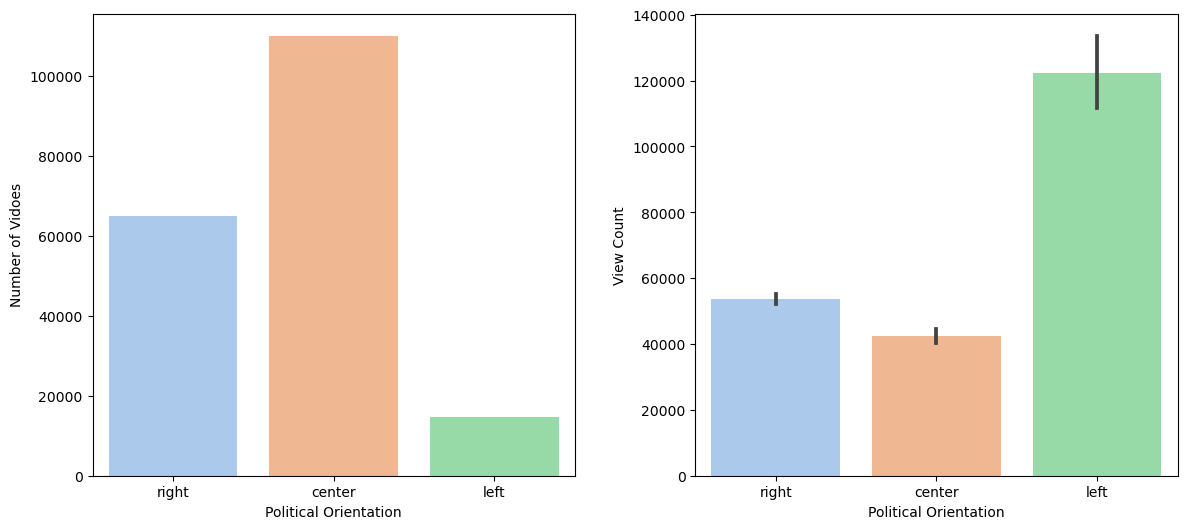

In [40]:
#plot for distrtibution of views/number of videos for right, left and center
videos_radic_df_temp = videos_radic_df.loc[videos_radic_df["pol_orient"] != 0]
#As part of the radicalization data, there was unclassified groups labelled as "0" that we dropped. 
#These were either PUA or "Intellectual Dark Web" that has supporters from both left and right so we couldn't clssify as one of the three.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"wspace": 0.25, "hspace": 0.1})

ax1 = sns.countplot(ax = ax1, x=videos_radic_df_temp["pol_orient"], palette="pastel")
ax1.set(xlabel='Political Orientation', ylabel='Number of Vidoes')
ax2 = sns.barplot(ax = ax2, data=videos_radic_df_temp, x = "pol_orient", y = "view_count", palette = "pastel")
ax2.set(xlabel='Political Orientation', ylabel='View Count')

plt.show()

As can be seen from the above graph, eventhough left wing is small in terms of numbers of vidoes produced compared to right and center, the views count is the highest among the three categories.

**Q3.3: Data Analysis**

**(a) Growth comparison of politically categorized videos in (pre-) election period of Donald Trump**

As described before, we study and compare the growth of the view_count for the three categorical videos ("left", "right" and "center") starting in the pre-election period of 2017.

In [11]:
videos_radic_df.upload_date = pd.to_datetime(videos_radic_df.upload_date, errors='coerce')
videos_radic_df = videos_radic_df.set_index("upload_date")
videos_radic_df = videos_radic_df[videos_radic_df.pol_orient != 0]

/var/folders/87/26kj3hvj3_b63zn9y6lwvtcc0000gn/T/ipykernel_11599/727714728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videos_radic_df.upload_date = pd.to_datetime(videos_radic_df.upload_date, errors='coerce')


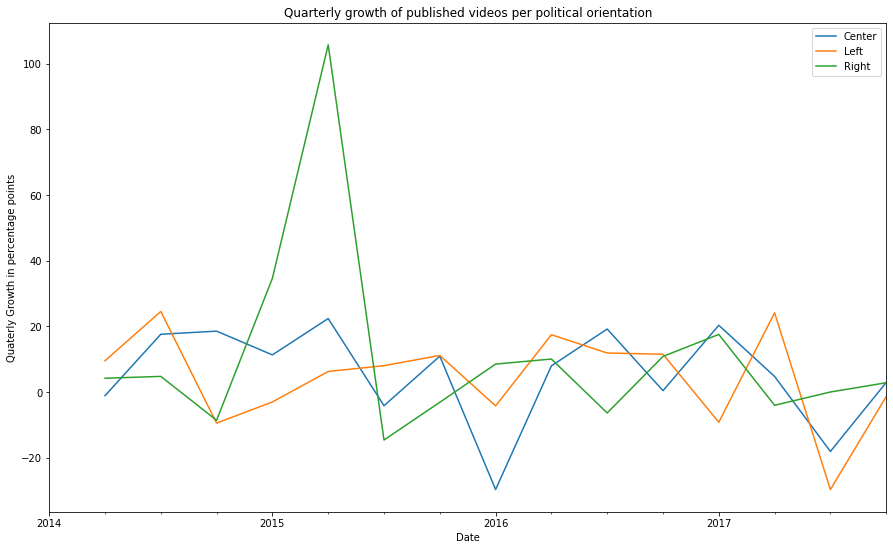

In [17]:
#growth of released videos per political orientation category ("left", "center", or "right") per quarter in the (pre-)election period of 2017
videos_sorted = videos_radic_df.groupby("pol_orient").resample("Q").title.count()
videos_sorted = videos_sorted.unstack(level=0).dropna()
videos_sorted = videos_sorted[videos_sorted.index > pd.Timestamp("2014-01-01")]
videos_sorted = videos_sorted[videos_sorted.index < pd.Timestamp("2018-01-01")]


perc_change = videos_sorted.pct_change()*100
perc_change.plot(figsize=(15, 9))
plt.title("Quarterly growth of published videos per political orientation")
plt.legend(["Center", "Left", "Right"])
plt.xlabel("Date")
plt.ylabel("Quaterly Growth in percentage points")

plt.show()

We can observe a very strong growth (over 100%) of published videos in the last quarter of 2014 and first quarter of 2015. Besides that, we cannot clearly say that either one of the three categories grew strictly stronger than the others. To get an additional view on the user engagement for the three different political categories, we will study in the following the Heat-metric of each of the political categories over time.

**(b) Heat-Metric comparison of politically categorized videos in (pre-) election period of Donald Trump**

Also as describe in before, we want to analyze also the the evolvement of the heat-metric during that period to assess the user engagement for the three different political categories. We have shown the feasibility of this metric-calculation in part 3-Q1-b, so we will apply it analoguously to this data-subset.

---
##### Sentiment analysis per political orientation in specific political topics.


We now try to compare the sentiment of right and left groups about some political topics and figures. it can tell us more about the differences in opinions regarding some topics between the left and right.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os 
from transformers import pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

videos_radic_df = pd.read_csv("data/yt_metadata_reduced_radic.tsv.gz")
channels_radic_df = pd.read_csv("data/radic.csv")

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
#categorize each of the channels (created a respective column "pol_orient")

#note that we dont categorize "Intellectual Dark Web", since it has supporters from left and right
right = ["Alt-lite", "Alt-right", "Incel", "MGTOW", "MRA", "right"]
left  = ["left"]

def pol_orientation(x):
    if x in right: 
        return "right"
    elif x in left:
        return "left"
    else:
        return 0
        
        
channels_radic_df["pol_orient"] = channels_radic_df.Category.apply(pol_orientation)

In [9]:
#match the pol_orient to the videos based on its channel
#takes a bit to run (~2 minutes)
def orient_match(x):
    var = channels_radic_df.loc[channels_radic_df["Id"] == x]["pol_orient"].values
    if len(var) > 0:
        return var[0]
    else:
        return 0

videos_radic_df["pol_orient"] = videos_radic_df["channel_id"].apply(orient_match)

In [10]:
# drop empty rows (--> here you could also drop other rows if the contain un-important words)
videos_radic_df = videos_radic_df[videos_radic_df.title != ""]
videos_radic_df = videos_radic_df[videos_radic_df.pol_orient != 0]

In [11]:
#faster sentiment analysis
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"

tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("pysentimiento/robertuito-sentiment-analysis")
model.eval().cuda()


# print(sentiment_pipeline._batch_size)
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, enc1, enc2, enc3):
        # print(len(encodings))
        self.enc1 = enc1
        self.enc2 = enc2
        self.enc3 = enc3
    def __len__(self):
        return len(self.enc1)
    def __getitem__(self, i):
        item = {'input_ids': torch.tensor(self.enc1[i]),
        'token_type_ids': torch.tensor(self.enc2[i]),
        'attention_mask': torch.tensor(self.enc3[i])}
        # item = {key: torch.tensor(val[i], requires_grad=False) for key, val in self.encodings.items()}
        return item

def sent_analysis(desc):
    # print(len(desc))
    encodings = tokenizer(desc, truncation=True, max_length=128, padding=True)
    dataset = MyDataset(encodings['input_ids'],
    encodings['token_type_ids'],
    encodings['attention_mask'])
    params = {'batch_size': 1024, 'shuffle': False, 'num_workers': 8}
    training_generator = torch.utils.data.DataLoader(dataset, **params)
    outs = []
    for bt in tqdm(training_generator):
        bt = {key: val.cuda() for key, val in bt.items()}
        with torch.no_grad():
            out = model(**bt)
            scores = torch.nn.functional.softmax(out['logits'], dim=1).detach().cpu().numpy()
        outs.append(scores)
    outs = np.concatenate(outs, axis=0)
    outs = np.concatenate([outs[:,0:1],outs[:,2:]], axis=1)
    clss = np.argmax(outs, axis=1)
    lbl = np.array(clss)
    lbl[clss == 0] = -1
    lbl[clss == 1] = 1
    #lbl[clss == 2] = 1 
    return lbl * np.max(outs, axis=1)

In [12]:
# helper function that adds one column for sentiment in a given daatset

def output(df):
    out  = sent_analysis(df['description'].to_list())
    df['score'] = out
    # df['heat'] = df['dislike_count'] / (df['like_count'] + df['dislike_count'])
    return df

In [13]:
# choosing the keywords we afre going to analyse..

videos_df = videos_radic_df[['pol_orient', 'description', 'like_count', 'dislike_count']]
keywords = ['obama', 'trump', 'hillary|clinton', 'russia', 'china', 'immigration|immigrant' , 'climate change', 'putin', 'police', 'women']
dfs = []
for kw in keywords:
    dfs.append(output(videos_df[videos_radic_df.description.str.contains(kw,na=False)]))


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


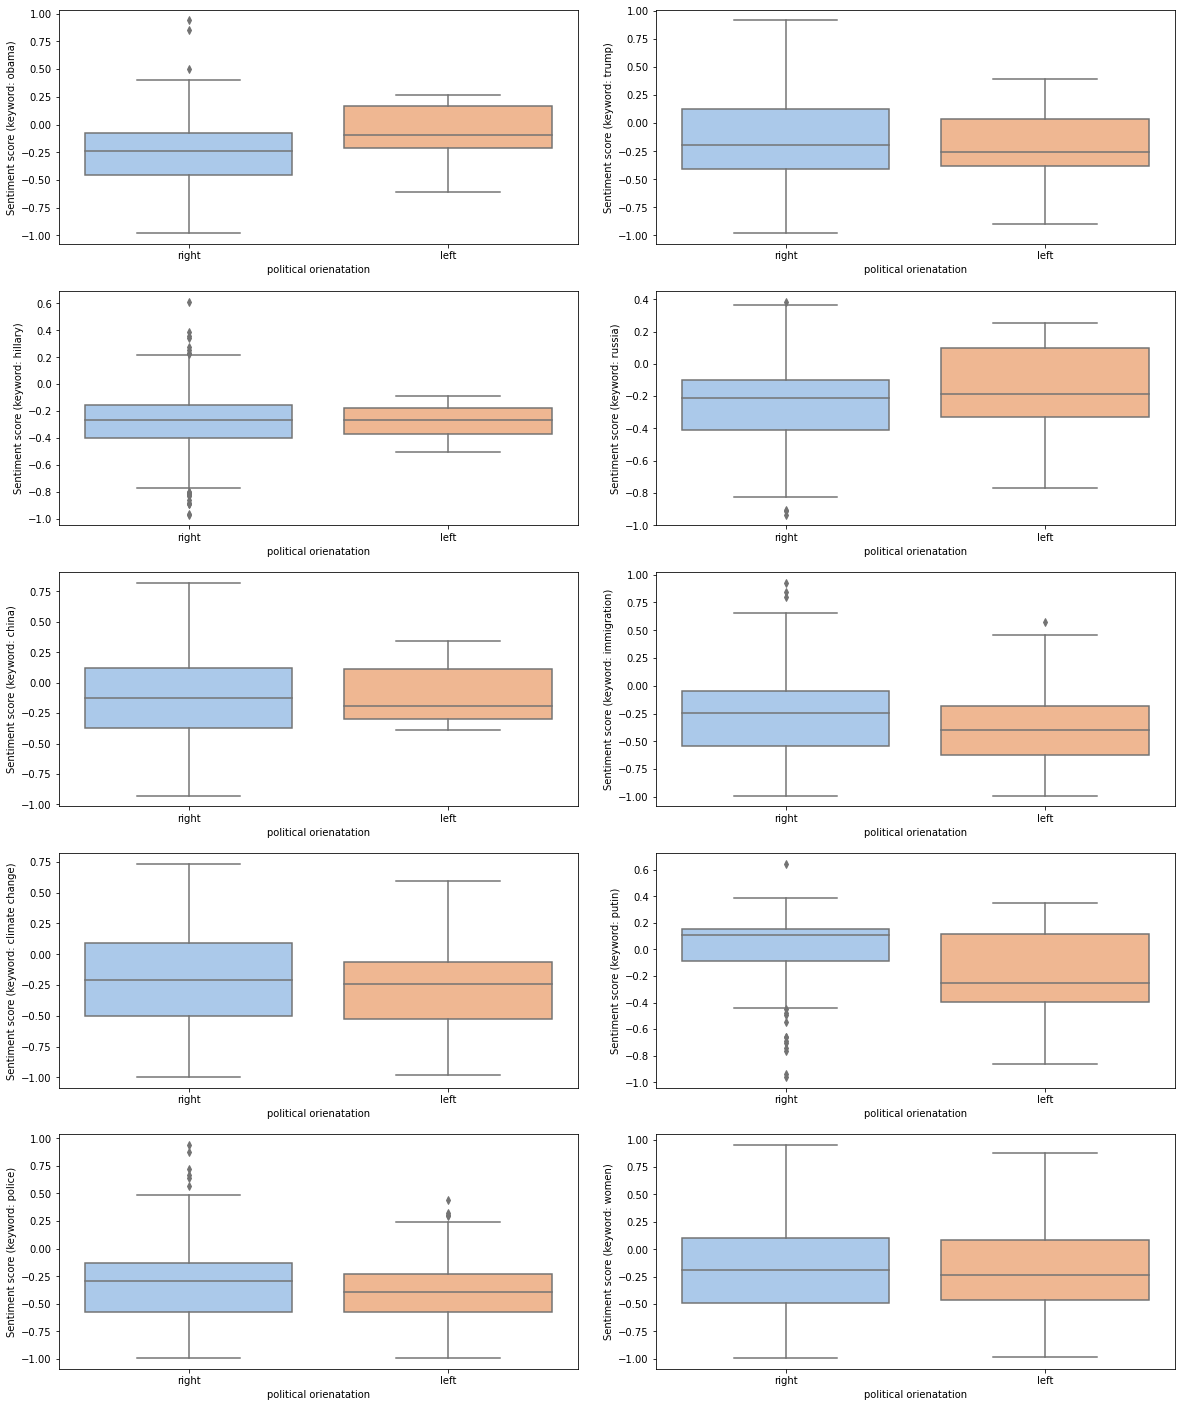

In [14]:
# plotting the sentiment per group as box plots to compare the sentiment
fig, axs = plt.subplots(5,2, figsize=(20,25),gridspec_kw={"wspace": 0.15, "hspace": 0.2})

for indx, df in enumerate(dfs):
    ax = axs[indx//2, indx%2]
    ax = sns.boxplot(ax = ax, data=df, x = df['pol_orient'], y = df['score'], palette="pastel")
    ax.set(xlabel='political orienatation', ylabel=f'Sentiment score (keyword: {keywords[indx].split("|")[0]})')

plt.show()

In [15]:
# doing regression analysis for each keyword..
np.random.seed(2)
for indx, df in enumerate(dfs):
    df['is_right'] = np.where((df['pol_orient'] == "right"), 1, 0)
    mod = smf.ols(formula='score ~ C(is_right)', data=df)
    # Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
    res = mod.fit()
    # Print thes summary output provided by the library.
    print(f"Regression Analysis for sentiment For Keyword: {keywords[indx]}\n", res.summary())

Regression Analysis for sentiment For Keyword: obama
                             OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     7.433
Date:                Fri, 23 Dec 2022   Prob (F-statistic):            0.00702
Time:                        18:47:27   Log-Likelihood:                -58.040
No. Observations:                 186   AIC:                             120.1
Df Residuals:                     184   BIC:                             126.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

The difference is statistically significant only for the keywords “immigration”, “Putin”, and “Police”. all the others has a P>|t| greater than 0.05

--- 
##### comparing sentiment per category on the dataset

In [16]:
# first, run on 20% random sample from the data. It takes 16 hours to run on 20% of the data

chunksize = (10 ** 6) // 2
flag=False
for chunk in tqdm(pd.read_json("data/yt_metadata_en.jsonl.gz",lines=True, chunksize=chunksize)): 
    # chunk = chunk.loc[chunk["categories"].isin(['Nonprofits & Activism', 'People & Blogs', 'News & Politics'])]
    drop_indices = np.random.choice(chunk.index, int(0.8*chunksize), replace=False)
    chunk = chunk.drop(drop_indices)
    dsc = chunk['description'].to_list()
    chunk = chunk.drop(['crawl_date', 'duration', 'description', 'tags', 'title'], axis=1)

    out = sent_analysis(dsc)
    #sentiment = pd.DataFrame.from_dict(out)
    #sentiment['label'] = sentiment['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
    #sentiment['score'] = sentiment['label']*sentiment['score']
    chunk['sent'] = out
    chunk['heat_metric'] = chunk['dislike_count'] / (chunk['like_count'] + chunk['dislike_count'])
    print(chunk.head())
    if not flag:
        flag=True
        chunk.to_csv('data_reduced/yt_metadata_reduced2.tsv.gz', index=False)
    else:
        chunk.to_csv('data_reduced/yt_metadata_reduced2.tsv.gz', index=False, header=False, mode='a')
    

In [18]:
# read the reduced data and do some filterations

from datetime import datetime
dt = pd.read_csv('data_reduced/yt_metadata_reduced2.tsv.gz')
dt['upload_date'] = pd.to_datetime(dt['upload_date'], errors='coerce')
dt = dt.loc[dt['upload_date']>=datetime(2008,1,1)]
dt = dt.loc[dt['categories'] != 'Shows']


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


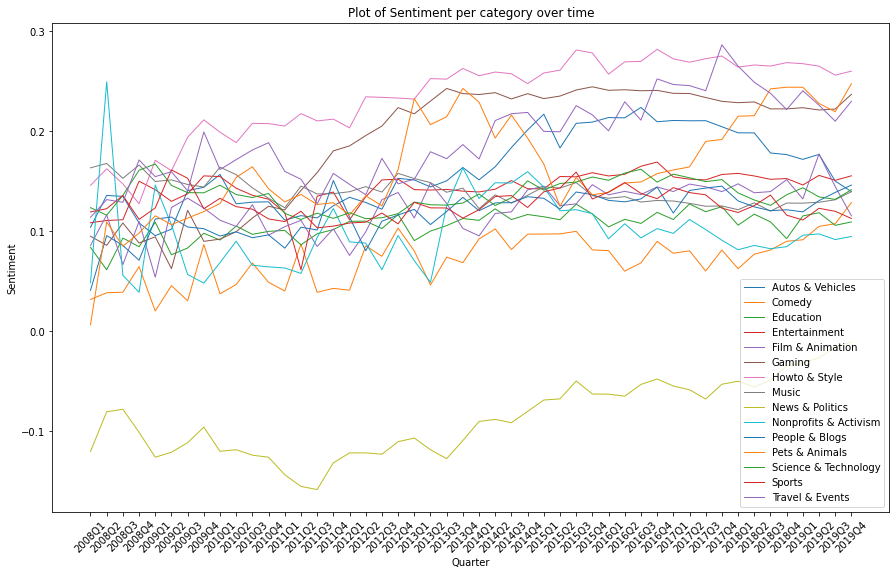

In [19]:
# plotting the sentiment overtime for each category
import seaborn as sns


grp_cat = dt.groupby(['categories'])
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.set_xticklabels(dt.groupby(pd.PeriodIndex(dt['upload_date'], freq="Q"))['sent'].mean().index.map(str).to_list(), rotation=45)
for grp in grp_cat:
    sent_mean = grp[1].groupby(pd.PeriodIndex(grp[1]['upload_date'], freq="Q"))['sent'].mean()
    sent_mean = pd.DataFrame({'mean_sent' : sent_mean}).reset_index()
    sent_mean = sent_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)
    ax.plot(sent_mean.index.map(str).to_list(), sent_mean['mean_sent'].to_list(), linewidth=1, label=grp[0])
    
    

plt.xlabel('Quarter')
plt.ylabel('Sentiment')
plt.title('Plot of Sentiment per category over time')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Sentiment Per Category')

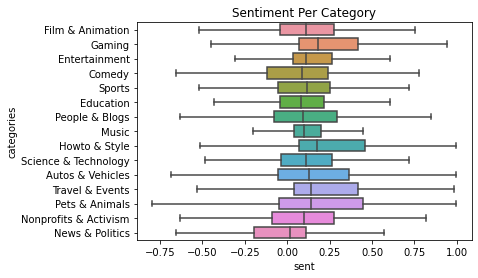

In [20]:
# boxplot of sentiment per category.
sns.boxplot(data=dt, y="categories", x="sent", showfliers=False).set_title('Sentiment Per Category')

--- 
##### comparing Heat per category on the dataset


/home/ewais/anaconda3/envs/deca-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


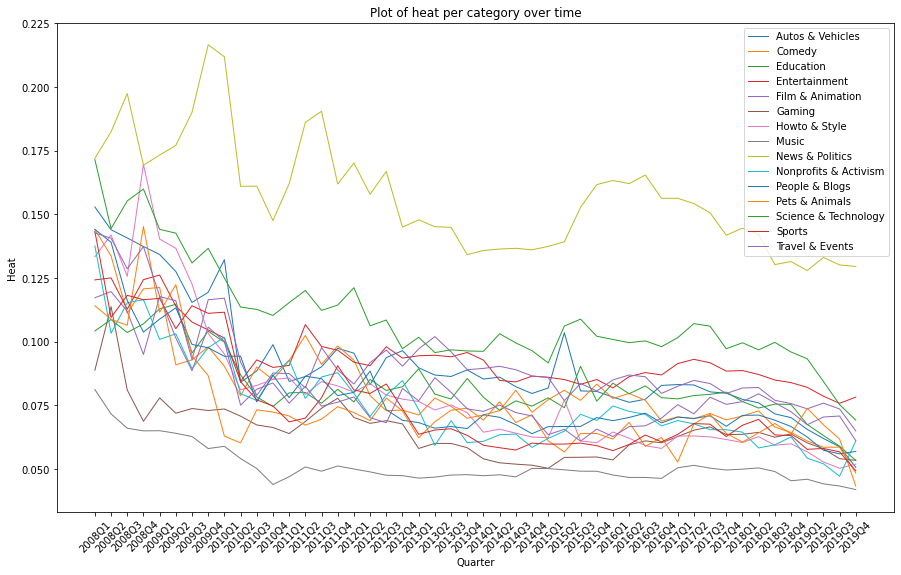

In [21]:
grp_cat = dt.groupby(['categories'])
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.set_xticklabels(dt.groupby(pd.PeriodIndex(dt['upload_date'], freq="Q"))['heat_metric'].mean().index.map(str).to_list(), rotation=45)
for grp in grp_cat:
    if grp[0] == 'Shows':
        continue
    # grp.groupby()
    sent_mean = grp[1].groupby(pd.PeriodIndex(grp[1]['upload_date'], freq="Q"))['heat_metric'].mean()
    sent_mean = pd.DataFrame({'mean_heat' : sent_mean}).reset_index()
    sent_mean = sent_mean.set_index('upload_date').resample('Q').asfreq().fillna(0)
    ax.plot(sent_mean.index.map(str).to_list(), sent_mean['mean_heat'].to_list(), linewidth=1, label=grp[0])
    
    

plt.xlabel('Quarter')
plt.ylabel('Heat')
plt.title('Plot of heat per category over time')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Heat Per Category')

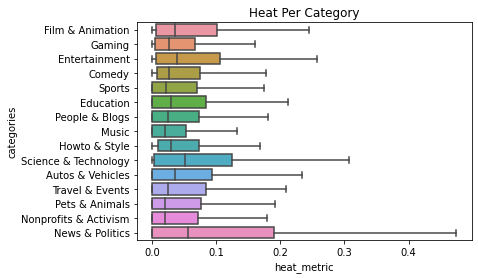

In [22]:
# box plot for heat per category.
sns.boxplot(data=dt, y="categories", x="heat_metric", showfliers=False).set_title('Heat Per Category')